In [1]:
import doctest
import io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
processed_otter = pd.read_csv("processed_data/otters_processed.csv")
processed_urchin = pd.read_csv("processed_data/urchins_processed.csv")
processed_shark = pd.read_csv("processed_data/sharks_processed.csv")
processed_kelp = pd.read_csv("processed_data/kelp_processed.csv")
processed_hotdays = pd.read_csv("processed_data/hotdays_processed.csv")

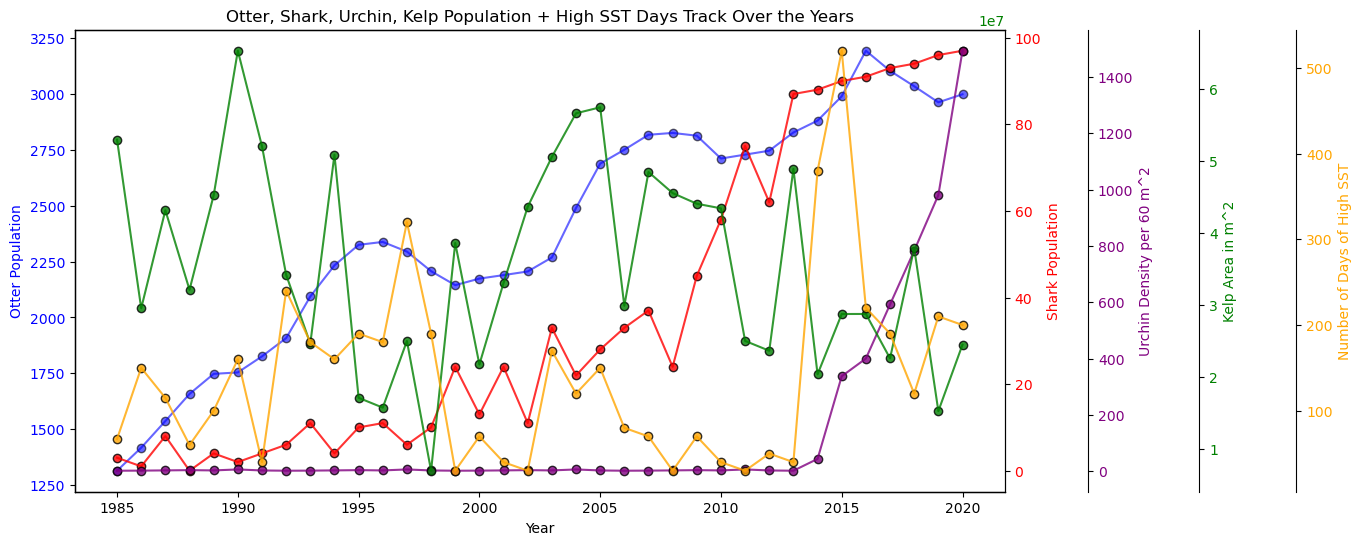

In [3]:
# Create the figure and first axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Otter Population
ax1.scatter(processed_otter["Year"], processed_otter["Total_Pop"], color="blue", alpha=0.6, edgecolors="black", label="Otter Population")
ax1.plot(processed_otter["Year"], processed_otter["Total_Pop"], color="blue", alpha=0.6)  # Connect points
ax1.set_xlabel("Year")
ax1.set_ylabel("Otter Population", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Shark Population
ax2 = ax1.twinx()
ax2.scatter(processed_shark["Year"], processed_shark["Total_Pop"], color="red", alpha=0.8, edgecolors="black", label="Shark Population")
ax2.plot(processed_shark["Year"], processed_shark["Total_Pop"], color="red", alpha=0.8)  # Connect points
ax2.set_ylabel("Shark Population", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Urchin Density
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))
ax3.scatter(processed_urchin["Year"], processed_urchin["Avg_Density"], color="purple", alpha=0.8, edgecolors="black", label="Urchin Density")
ax3.plot(processed_urchin["Year"], processed_urchin["Avg_Density"], color="purple", alpha=0.8)  # Connect points
ax3.set_ylabel("Urchin Density per 60 m^2", color="purple")
ax3.tick_params(axis="y", labelcolor="purple")

# Kelp Area
ax4 = ax1.twinx()
ax4.spines["right"].set_position(("outward", 140))
ax4.scatter(processed_kelp["Year"], processed_kelp["Total_Area"], color="green", alpha=0.8, edgecolors="black", label="Kelp Area")
ax4.plot(processed_kelp["Year"], processed_kelp["Total_Area"], color="green", alpha=0.8)  # Connect points
ax4.set_ylabel("Kelp Area in m^2", color="green")
ax4.tick_params(axis="y", labelcolor="green")

# High SST Days
ax5 = ax1.twinx()
ax5.spines["right"].set_position(("outward", 210))
ax5.scatter(processed_hotdays["Year"], processed_hotdays["Hot_Days"], color="orange", alpha=0.8, edgecolors="black", label="High SST Days")
ax5.plot(processed_hotdays["Year"], processed_hotdays["Hot_Days"], color="orange", alpha=0.8)  # Connect points
ax5.set_ylabel("Number of Days of High SST", color="orange")
ax5.tick_params(axis="y", labelcolor="orange")

# Title
 
# Show the plot
plt.show()

# Solving for constants

# Naive ODE using constants only (no kelp, no temp)

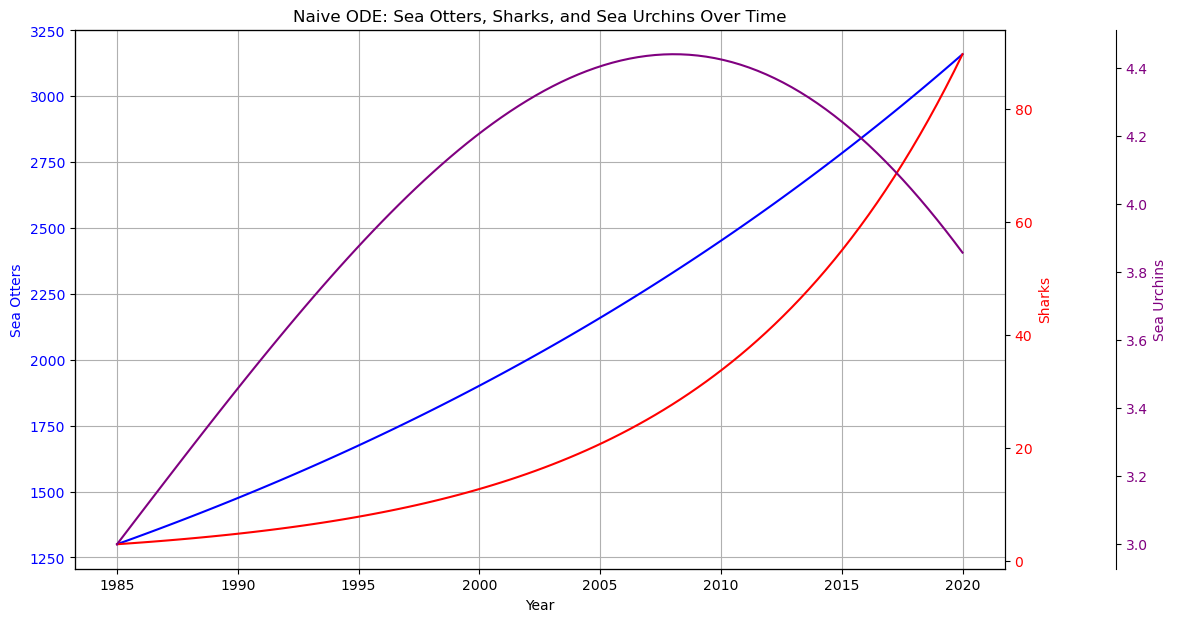

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define constant parameters
a = 0.07  
b = 0.00003

d = 0.025
e = 0.0001
f = 0.000001

g = 0.095
h = 0.000001

# Define the system of ODEs based on your equations
def system(y, t, a, b, d, e, f, g, h):
    U, R, S = y
    dU_dt = a * U - b * U * R
    dR_dt = d * R + e * U * R - f * S * R
    dS_dt = g * S + h * S * R
    return [dU_dt, dR_dt, dS_dt]

# Initial conditions: [U, R, S]
y0 = [3, 1300, 3]

# Time span
t = np.linspace(1985, 2020, 100)

# Solve the system:
solution = odeint(system, y0, t, args=(a, b, d, e, f, g, h))

# Extract the solution for each species
U = solution[:, 0]  # Sea urchins
R = solution[:, 1]  # Sea otters
S = solution[:, 2]  # Sharks

# Create figure and first axis
fig, ax1 = plt.subplots(figsize=(12, 7))

# First y-axis (Sea otters)
ax1.plot(t, R, color="blue", label="Sea Otters")
ax1.set_ylabel("Sea Otters", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Second y-axis (Sharks)
ax2 = ax1.twinx()
ax2.plot(t, S, color="red", label="Sharks")
ax2.set_ylabel("Sharks", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Third y-axis (Sea urchins)
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 80))  # Offset third axis to avoid overlap
ax3.plot(t, U, color="purple", label="Sea Urchins")
ax3.set_ylabel("Sea Urchins", color="purple")
ax3.tick_params(axis="y", labelcolor="purple")

# Title and grid
plt.title("Naive ODE: Sea Otters, Sharks, and Sea Urchins Over Time")
ax1.grid(True)
ax1.set_xlabel("Year")

# Show the plot
plt.show()


# Improved ODE With Kelp/Temperature Functions

C:\Users\dorae\AppData\Local\Temp\ipykernel_22012\1776953210.py:48: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(system, y0, t, args=(a, b, d, e, f, g, h, c, i))


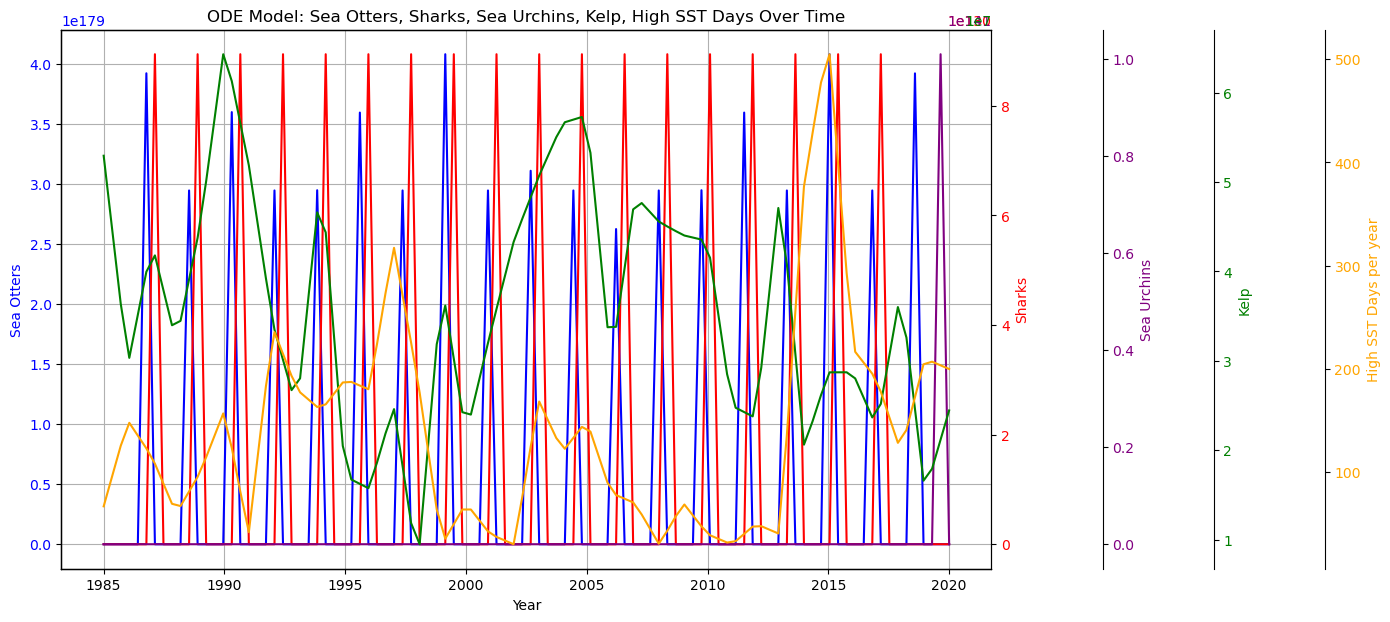

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interp1d

# Interpolate T and K over the time range
t = np.linspace(1985, 2020, 100)
T_interp = interp1d(processed_hotdays['Year'], processed_hotdays['Hot_Days'], kind='linear', fill_value='extrapolate')
K_interp = interp1d(processed_kelp['Year'], processed_kelp['Total_Area'], kind='linear', fill_value='extrapolate')

# Create arrays for plotting
T_vals = T_interp(t)
K_vals = K_interp(t)

# Define constant parameters
a = 0.07  
b = 0.0

d = 0.025
e = 0.0
f = 0.00

g = 0.1
h = 0.0

i = 0.0000
c = 13.5  # Reference temperature for the absolute value term

# Define the system of ODEs based on your equations
def system(y, t, a, b, d, e, f, g, h, c, i):
    U, R, S = y
    T = T_interp(t)  # Interpolated temperature at time t
    K = K_interp(t)  # Interpolated carrying capacity at time t
    
    # Updated ODE equations with T and K terms
    #dU_dt = a * U - b * U * R + abs(T - c) * i * U
    dU_dt = a * U - b * U * R
    dR_dt = d *K * R + e * U * R - (f / K) * S * R
    dS_dt = g * S + (h / K) * S * R
    
    return [dU_dt, dR_dt, dS_dt]

# Initial conditions: [U, R, S]
y0 = [3, 1300, 3]

# Solve the system
solution = odeint(system, y0, t, args=(a, b, d, e, f, g, h, c, i))

# Extract the solution for each species
U = solution[:, 0]  # Sea urchins
R = solution[:, 1]  # Sea otters
S = solution[:, 2]  # Sharks

# Create figure and first axis
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot Sea Otters
ax1.plot(t, R, color="blue", label="Sea Otters")
ax1.set_ylabel("Sea Otters", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Plot Sharks
ax2 = ax1.twinx()
ax2.plot(t, S, color="red", label="Sharks")
ax2.set_ylabel("Sharks", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Plot Sea Urchins
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 80))
ax3.plot(t, U, color="purple", label="Sea Urchins")
ax3.set_ylabel("Sea Urchins", color="purple")
ax3.tick_params(axis="y", labelcolor="purple")

# Plot Kelp (using saved K values)
ax4 = ax1.twinx()
ax4.spines["right"].set_position(("outward", 160))
ax4.plot(t, K_vals, color="green", label="Kelp")
ax4.set_ylabel("Kelp", color="green")
ax4.tick_params(axis="y", labelcolor="green")

# Plot High SST Days (using saved T values)
ax5 = ax1.twinx()
ax5.spines["right"].set_position(("outward", 240))
ax5.plot(t, T_vals, color="orange", label="Number of High SST Days")
ax5.set_ylabel("High SST Days per year", color="orange")
ax5.tick_params(axis="y", labelcolor="orange")

# Title and grid
plt.title("ODE Model: Sea Otters, Sharks, Sea Urchins, Kelp, High SST Days Over Time")
ax1.grid(True)
ax1.set_xlabel("Year")

# Show the plot
plt.show()